- LSTM
  - RNN을 발전시킨 형태
  - 장기기억을 담당하는 셀 상태와 은닉상태를 갖는 신경망
- BOW
  - 모든 단어를 겹치지 않도록 고유 번호로 나타낸 집합
- 희소표현
  - 대부분의  숫자가 0으로 구성된 숫자표현
- 파이토치의 임베디드층
  - 희소표현을 밀집표현으로 변경할 수 있다  

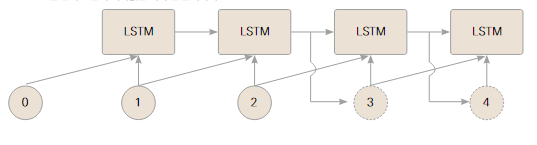

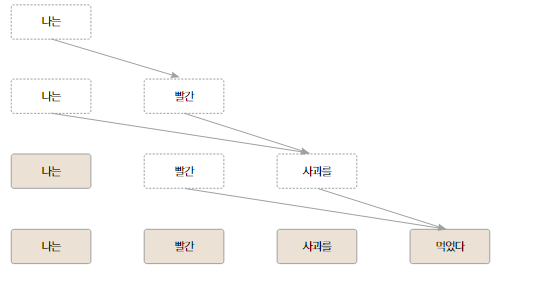

In [2]:
# 뉴욕타임즈 코멘트 데이터 사용 - from kaggle
# 바로가기 : https://drive.google.com/file/d/1yWWIwv8-4mE4qCCTj3i8xtzovupM_31s/view?usp=sharing

In [3]:
import pandas as pd

In [ ]:
!unzip '/content/drive/MyDrive/NYT-COMMENT-TEXT/archive.zip'

In [5]:
df = pd.read_csv('/content/ArticlesApril2017.csv')
df.head(2)

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...


In [6]:
# 학습용 데이터 만들기
# 1.전처리(구두점하고 특수문자 제거)
# 2.단어마다 고유번호를 만들어준다
# 3. 문장속 단어들을 전부 고유번호로 바꿔준다
# BOW(Bag of Word)

In [8]:
from collections import Counter

In [11]:
c = Counter('gallahad')
c

Counter({'g': 1, 'a': 3, 'l': 2, 'h': 1, 'd': 1})

In [12]:
import numpy as np
import glob
from torch.utils.data.dataset import Dataset

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
class TextGeneration(Dataset):
  def clean_text(self, txt):
    # 문장에서 punctuation를제거하고 전부 소문자로 변경
    return "".join([character for character in txt if character not in string.punctuation])
  def __init__(self,file_path='./*Articles*.csv'):
    all_headlines=[]
    # 헤드라인의 텍스트를 가져옴
    for filename in glob.glob(file_path):  # 000/0000/*Articles*.csv
      article_df = pd.read_csv(filename)
      all_headlines.extend( list(article_df['headline'].values) )

    # Unknown 값 제거
    all_headlines = [h for h in  all_headlines if h != 'Unknown']

    # punctuation 제거
    self.corpus =  [self.clean_text(h) for h in all_headlines]
    self.BOW = {}

    # 모든 문장의 단어를 추출해서 고유번호 지정


In [19]:
(df['headline'] == 'Unknown').sum()

55